# <center><h1>Recurrent Neural Network from Scratch</h1></center>

- Data from https://towardsdatascience.com/recurrent-neural-networks-56e1ad215339
- Implementation from https://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

In [79]:
X = torch.tensor([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0],
    [0, 1],
], dtype=torch.float32, device=device)

Y = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1],
    [1, 0, 0],
], dtype=torch.float32, device=device)

In [80]:
num_inputs = X.shape[1]
num_outputs = Y.shape[1]
print("num_inputs", num_inputs)
print("num_outputs", num_outputs)

num_inputs 2
num_outputs 3


## Model

This is a very simple RNN architecture as it does not contain a hidden layer. It has two sets of weights, $W_{xy}$ and $W_{yx}$ corresponding to input-to-output connections and previous output-to-input connections, respectively.

<table>
    <tr align="center">
        <td><strong>RNN</strong></td>
        <td><strong>Unrolled RNN</strong></td>
        <td><strong>Unfolded RNN</strong></td>
    </tr>
    <tr>
        <td>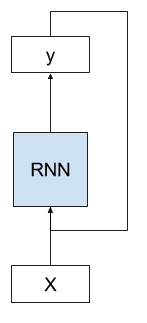</td>
        <td>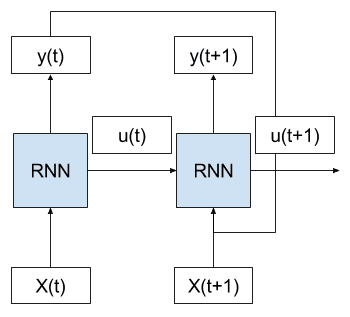</td>
        <td>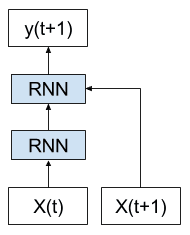</td>
    </tr>
    <caption>Image from <a href="https://machinelearningmastery.com/rnn-unrolling/">A Gentle Introduction to RNN Unrolling</a></caption>
</table>

In [85]:
class RNN:
    def __init__(self, num_inputs, num_weathers, num_outputs):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        # parameters
        self.W_xy = torch.rand((num_inputs, num_weathers), device=device, requires_grad=True) * 0.01
        self.W_yx = torch.rand((num_inputs, num_outputs), device=device, requires_grad=True) * 0.01

#         self.W_xy = torch.tensor([
#             # weather
#             [1,0], # yesterday
#             [1,0], # yesterday
#             [1,0], # yesterday
#             #----#
#             [0,1], # next
#             [0,1], # next
#             [0,1], # next
#         ], dtype=torch.float32, device=device)
#         self.W_yx = torch.tensor([
#             # food
#             [1,0,0], # yesterday
#             [0,1,0], # yesterday  =>  sunny = no change food
#             [0,0,1], # yesterday
#             #------#
#             [0,0,1], # next
#             [1,0,0], # next  =>  rainy = change food to next
#             [0,1,0], # next
#         ], dtype=torch.float32, device=device)

        self.params = [self.W_xy, self.W_yx]
    
    def parameters(self):
        return self.params
            
    def __call__(self, x, prev_y):
        o_x = torch.mm(rnn.W_xy, x[:, None])
        o_y = torch.mm(rnn.W_yx, prev_y[:, None])
        
        o_add = o_x + o_y
        
        o_nonlinear = torch.zeros_like(o_add)
        o_nonlinear[torch.argmax(o_add)] = 1
        
        half_idx = int(len(o_nonlinear)/2)
        o_merge1 = o_nonlinear[:half_idx]
        o_merge2 = o_nonlinear[half_idx:]
        o_merge = torch.cat((o_merge1, o_merge2), axis=1)
        o_merge = torch.sum(o_merge, axis=1)
        
        return o_merge

    def begin_state(self, num_prev):
        return torch.zeros_like(num_prev, device=device)

In [86]:
rnn = RNN(num_inputs=6, num_weathers=2, num_outputs=3)

In [87]:
def get_input(x):
    inputs = ("sunny", "rainy")
    return inputs[torch.argmax(x)]

def get_class(o):
    classes = ("pie", "burger", "chicken")
    if torch.max(o) == 0:
        return "nothing"
    return classes[torch.argmax(o)]

In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rnn.parameters(), 1e-3)

ValueError: can't optimize a non-leaf Tensor

In [73]:
O = torch.full_like(Y, float('nan'))
for i in range(len(X)):
    x = torch.autograd.Variable(torch.FloatTensor(X[i]), requires_grad=True)
    y = torch.autograd.Variable(torch.FloatTensor(Y[i]), requires_grad=True)
    
    if i - 1 < 0:
        y_prev = torch.zeros_like(Y[0])
    else:
        y_prev = o#Y[i-1]
    
    optimizer.zero_grad()
    
    o = rnn(x, y_prev)
    O[i] = o
    print(get_input(x), "+", get_class(y_prev), '=', get_class(O[i]), '|', get_class(y))
    
    o_class = torch.tensor([o.argmax()]).float().expand(1, -1)
    y_class = torch.tensor([y.argmax()])
#     X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)
    print("o_class", o_class.shape)
    print("y_class", y_class.shape)
    loss = criterion(o, y_class)
    loss.backward()
    optimizer.step()

sunny + nothing = pie | pie
o_class torch.Size([1, 1])
y_class torch.Size([1])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [40]:
o_class.view(-1).shape, o_class.shape

(torch.Size([1]), torch.Size([]))

In [34]:
criterion(torch.tensor([0]), torch.tensor([1]))

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
import matplotlib.image as image

foods = ['pie', 'burger', 'chicken']
food_images = []
for food in foods:
    img = image.imread(f'images/{food}.png')
    food_images.append(img)

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig, ax = plt.subplots(figsize=(12, 4), nrows=2, dpi=600)

ax[0].plot(torch.argmax(Y, axis=1), '--^', color='red', label="[actual] Food", alpha=0.4)
ax[0].plot(torch.argmax(O, axis=1), '-.s', color='blue', label="[predicted] Food", alpha=0.4)
ax[0].set_xticks(torch.arange(len(O)))
ax[0].set_ylabel('Food')
foods = ['pie', 'burger', 'chicken']
food_values = torch.arange(len(foods))
ax[0].set_yticks(food_values)
ax[0].set_yticklabels(foods)
ax[0].legend()
# ax[0].add_artist(
#     AnnotationBbox(
#         OffsetImage(food_images[0]),
#         (1, 1),
#         frameon=False,
#     ) 
# )

ax[1].plot(torch.argmax(X, axis=1), '-o', color='black')
ax[1].set_xticks(torch.arange(len(X)))
ax[1].set_ylabel('Weather')
weathers = ['sunny', 'rainy']
weather_values = torch.arange(len(weathers))
ax[1].set_yticks(weather_values)
ax[1].set_yticklabels(weathers)
ax[1].legend()
plt.show()